<center>

# Maxwell in 2D

## Daniil Stefonishin, Skoltech Moscow

<font size=4>Email: <d.stefonishin@skoltech.ru> </font>

$
    \mathbf{E} = \left(E_{x}, E_{y}, E_{z}\right) = \mathbf{E}\!\left(t, x, z\right)
$,

$
    \mathbf{B} = \left(B_{x}, B_{y}, B_{z}\right) = \mathbf{B}\!\left(t, x, z\right)
$,

$$
    \begin{cases}
        \displaystyle
        \nabla \times \mathbf{E} = - \frac{\partial \mathbf{B}}{\partial t}
    \\
        \displaystyle
        \nabla \times \mathbf{B} = \frac{\partial \mathbf{E}}{\partial t}
    \end{cases}
$$

### Vanilla python version

In [8]:
%pylab inline
import copy
from numba import jit

Populating the interactive namespace from numpy and matplotlib


In [3]:
# parameters

a0 = 1.
w0 = 2.
phi0 = 0.
w = 1.
T = 5 * 2 * pi
k = 1.
nofxs = 200
nofzs = 200

Lx = 10 * 2 * pi
Lz = 10 * 2 * pi

x = linspace(-Lx / 2., Lx / 2., nofxs)
z = linspace(0., Lz, nofzs)

dx = x[1] - x[0]
dz = z[1] - z[0]
dt = dx / sqrt(2) * 0.9

N = 1000

rx = dt / dx
rz = dt / dz

print(rx, rz, rx ** 2 + rz ** 2, dt, N * dt)

0.6363961030678927 0.6363961030678893 0.8099999999999956 0.20093440423831696 200.93440423831697


In [4]:
# definitions
import math
def Envelope(t, z):
    return sin(pi * (t - z) / T) ** 2 if abs(t - z) < T else 0.

def Source(t, x, z = 0):
    return a0 * exp(-(x / w0) ** 2 / 2) * sin(w * t - k * z + phi0) * Envelope(t, z)

# By0[i, j] ~ By n-1/2 i     j+1/2
# Ex0[i, j] ~ Ex n     i     j
# Ez0[i, j] ~ Ez n     i+1/2 j+1/2

def iterate(Ex0, Ex1, Ez0, Ez1, By0, By1, n):
    for i in range(nofxs):
        for j in range(nofzs):
            # Dt By = Dx Ez - Dz Ex
            if j == 0:
                By1[i, 0] = Source(dt * (n - 0.5), -Lx / 2. + i * dx, dz / 2.)
            elif j == nofzs - 1:
                By1[i, nofzs - 1] = 0.
            elif i == 0:
                By1[0, j] = By0[0, j] \
                    + rx * (Ez0[0, j] - Ez0[nofxs - 1, j]) \
                    - rz * (Ex0[0, j + 1] - Ex0[0, j])
            elif i == nofxs - 1:
                By1[nofxs - 1, j] = By0[nofxs - 1, j] \
                    + rx * (Ez0[0, j] - Ez0[nofxs - 1, j]) \
                    - rz * (Ex0[nofxs - 1, j + 1] - Ex0[nofxs - 1, j])
            else:
                By1[i, j] = By0[i, j] \
                    + rx * (Ez0[i, j] - Ez0[i - 1, j]) \
                    - rz * (Ex0[i, j + 1] - Ex0[i, j])

    for i in range(nofxs):
        for j in range(nofzs):
            # Dt Ez = Dx By
            if i == nofxs - 1:
                Ez1[nofxs - 1, j] = Ez0[0, j] + rx * (By1[1, j] - By1[0, j])
            elif j == nofzs - 1:
                Ez1[i, nofzs - 1] = 0.
            else:
                Ez1[i, j] = Ez0[i, j] + rx * (By1[i + 1, j] - By1[i, j])

            # Dt Ex = Dz By
            if j == 0:
                Ex1[i, 0] = Source(dt * n, -Lx / 2. + i * dx, 0.)
            elif j == nofzs - 1:
                Ex1[i, nofzs - 1] = 0.
            else:
                Ex1[i, j] = Ex0[i, j] - rz * (By1[i, j] - By1[i, j - 1])
    
    for i in range(nofxs):
        for j in range(nofzs):
            Ex0[i, j] = Ex1[i, j]
            Ez0[i, j] = Ez1[i, j]
            By0[i, j] = By1[i, j]

In [1]:
!rm -rf *.png; rm -rf *.mp4; rm -rf *.npy

Zero initial conditions

$E_{x}\!\left(0, x, z\right) = E_{z}\!\left(0, x, z\right) = B_{y}\!\left(0, x, z\right) = 0$

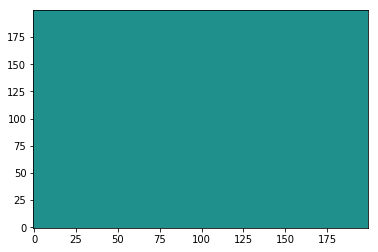

In [28]:
# initial condition

n = 0

Ex0 = np.zeros((nofxs, nofzs))
Ez0 = np.zeros((nofxs, nofzs))
By0 = np.zeros((nofxs, nofzs))

Ex1 = np.empty((nofxs, nofzs))
Ez1 = np.empty((nofxs, nofzs))
By1 = np.empty((nofxs, nofzs))

imshow(Ex1, aspect = 'auto', origin = 'lower', vmin = -a0, vmax = a0)
imsave('dump%05d.png' % 0, Ex1, vmin = -a0, vmax = a0)

1.69 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


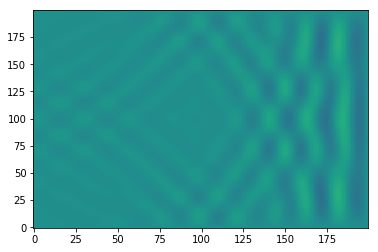

In [29]:
%%timeit -n 1 -r 1

for n in range(N):
    iterate(Ex0, Ex1, Ez0, Ez1, By0, By1, n + 1)

    if (n + 1) % 10 == 0: 
        imshow(Ex1, aspect = 'auto', origin = 'lower', vmin = -a0, vmax = a0)
        imsave('dump%05d.png' % (n + 1), Ex1, vmin = -a0, vmax = a0)
        
    if (n + 1) % 100 == 0:
        save('check%05d' % (n + 1), Ex1)

### JIT-compiled python version

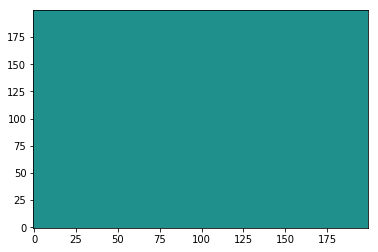

In [89]:
# initial condition

n = 0

Ex0 = np.zeros((nofxs, nofzs))
Ez0 = np.zeros((nofxs, nofzs))
By0 = np.zeros((nofxs, nofzs))

Ex1 = np.empty((nofxs, nofzs))
Ez1 = np.empty((nofxs, nofzs))
By1 = np.empty((nofxs, nofzs))

imshow(Ex1, aspect = 'auto', origin = 'lower', vmin = -a0, vmax = a0)
imsave('dump%05d.png' % 0, Ex1, vmin = -a0, vmax = a0)

In [90]:
# definitions

@jit
def Envelope(t, z):
    return sin(pi * (t - z) / T) ** 2 if abs(t - z) < T else 0.

@jit
def Source(t, x, z = 0):
    return a0 * exp(-(x / w0) ** 2 / 2) * sin(w * t - k * z + phi0) * Envelope(t, z)


# By0[i, j] ~ By n-1/2 i     j+1/2
# Ex0[i, j] ~ Ex n     i     j
# Ez0[i, j] ~ Ez n     i+1/2 j+1/2

@jit
def iterate(Ex0, Ex1, Ez0, Ez1, By0, By1, n):
    for i in range(nofxs):
        for j in range(nofzs):
            # Dt By = Dx Ez - Dz Ex
            if j == 0:
                By1[i, 0] = Source(dt * (n - 0.5), -Lx / 2. + i * dx, dz / 2.)
            elif j == nofzs - 1:
                By1[i, nofzs - 1] = 0.
            elif i == 0:
                By1[0, j] = By0[0, j] \
                    + rx * (Ez0[0, j] - Ez0[nofxs - 1, j]) \
                    - rz * (Ex0[0, j + 1] - Ex0[0, j])
            elif i == nofxs - 1:
                By1[nofxs - 1, j] = By0[nofxs - 1, j] \
                    + rx * (Ez0[0, j] - Ez0[nofxs - 1, j]) \
                    - rz * (Ex0[nofxs - 1, j + 1] - Ex0[nofxs - 1, j])
            else:
                By1[i, j] = By0[i, j] \
                    + rx * (Ez0[i, j] - Ez0[i - 1, j]) \
                    - rz * (Ex0[i, j + 1] - Ex0[i, j])

    for i in range(nofxs):
        for j in range(nofzs):
            # Dt Ez = Dx By
            if i == nofxs - 1:
                Ez1[nofxs - 1, j] = Ez0[0, j] + rx * (By1[1, j] - By1[0, j])
            elif j == nofzs - 1:
                Ez1[i, nofzs - 1] = 0.
            else:
                Ez1[i, j] = Ez0[i, j] + rx * (By1[i + 1, j] - By1[i, j])

            # Dt Ex = Dz By
            if j == 0:
                Ex1[i, 0] = Source(dt * n, -Lx / 2. + i * dx, 0.)
            elif j == nofzs - 1:
                Ex1[i, nofzs - 1] = 0.
            else:
                Ex1[i, j] = Ex0[i, j] - rz * (By1[i, j] - By1[i, j - 1])
    
    for i in range(nofxs):
        for j in range(nofzs):
            Ex0[i, j] = Ex1[i, j]
            Ez0[i, j] = Ez1[i, j]
            By0[i, j] = By1[i, j]

6.39 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


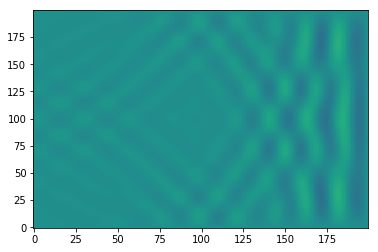

In [91]:
%%timeit -n 1 -r 1

for n in range(N):
    iterate(Ex0, Ex1, Ez0, Ez1, By0, By1, n + 1)

    if (n + 1) % 2 == 0: 
        imshow(Ex1, aspect = 'auto', origin = 'lower', vmin = -a0, vmax = a0)
        imsave('dump%05d.png' % (n + 1), Ex1, vmin = -a0, vmax = a0)
        
    if (n + 1) % 100 == 0:
        save('jitcheck%05d' % (n + 1), Ex1)

#### Solution check

In [23]:
a = load('check00300.npy')
b = load('jitcheck00300.npy')

plot((a - b)[:, 10])

FileNotFoundError: [Errno 2] No such file or directory: 'check00300.npy'

### Python + CUDA version

In [9]:
from numba import cuda

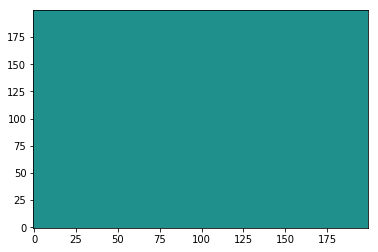

In [5]:
# initial condition

n = 0

Ex0 = np.zeros((nofxs, nofzs))
Ez0 = np.zeros((nofxs, nofzs))
By0 = np.zeros((nofxs, nofzs))

Ex1 = np.empty((nofxs, nofzs))
Ez1 = np.empty((nofxs, nofzs))
By1 = np.empty((nofxs, nofzs))

imshow(Ex1, aspect = 'auto', origin = 'lower', vmin = -a0, vmax = a0)
imsave('dump%05d.png' % 0, Ex1, vmin = -a0, vmax = a0)

In [10]:
# definitions

@jit
def Envelope(t, z):
    return sin(pi * (t - z) / T) ** 2 if abs(t - z) < T else 0.

@jit
def Source(t, x, z = 0):
    return a0 * exp(-(x / w0) ** 2 / 2) * sin(w * t - k * z + phi0) * Envelope(t, z)


# By0[i, j] ~ By n-1/2 i     j+1/2
# Ex0[i, j] ~ Ex n     i     j
# Ez0[i, j] ~ Ez n     i+1/2 j+1/2

@cuda.jit
def iterate(Ex0, Ex1, Ez0, Ez1, By0, By1, n):
    for i in range(nofxs):
        for j in range(nofzs):
            # Dt By = Dx Ez - Dz Ex
            if j == 0:
                By1[i, 0] = Source(dt * (n - 0.5), -Lx / 2. + i * dx, dz / 2.)
            elif j == nofzs - 1:
                By1[i, nofzs - 1] = 0.
            elif i == 0:
                By1[0, j] = By0[0, j] \
                    + rx * (Ez0[0, j] - Ez0[nofxs - 1, j]) \
                    - rz * (Ex0[0, j + 1] - Ex0[0, j])
            elif i == nofxs - 1:
                By1[nofxs - 1, j] = By0[nofxs - 1, j] \
                    + rx * (Ez0[0, j] - Ez0[nofxs - 1, j]) \
                    - rz * (Ex0[nofxs - 1, j + 1] - Ex0[nofxs - 1, j])
            else:
                By1[i, j] = By0[i, j] \
                    + rx * (Ez0[i, j] - Ez0[i - 1, j]) \
                    - rz * (Ex0[i, j + 1] - Ex0[i, j])

    for i in range(nofxs):
        for j in range(nofzs):
            # Dt Ez = Dx By
            if i == nofxs - 1:
                Ez1[nofxs - 1, j] = Ez0[0, j] + rx * (By1[1, j] - By1[0, j])
            elif j == nofzs - 1:
                Ez1[i, nofzs - 1] = 0.
            else:
                Ez1[i, j] = Ez0[i, j] + rx * (By1[i + 1, j] - By1[i, j])

            # Dt Ex = Dz By
            if j == 0:
                Ex1[i, 0] = Source(dt * n, -Lx / 2. + i * dx, 0.)
            elif j == nofzs - 1:
                Ex1[i, nofzs - 1] = 0.
            else:
                Ex1[i, j] = Ex0[i, j] - rz * (By1[i, j] - By1[i, j - 1])
    
    for i in range(nofxs):
        for j in range(nofzs):
            Ex0[i, j] = Ex1[i, j]
            Ez0[i, j] = Ez1[i, j]
            By0[i, j] = By1[i, j]

In [11]:
%%timeit -n 1 -r 1

for n in range(N):
    iterate(Ex0, Ex1, Ez0, Ez1, By0, By1, n + 1)

    if (n + 1) % 2 == 0: 
        imshow(Ex1, aspect = 'auto', origin = 'lower', vmin = -a0, vmax = a0)
        imsave('dump%05d.png' % (n + 1), Ex1, vmin = -a0, vmax = a0)
        
    if (n + 1) % 100 == 0:
        save('jitcheck%05d' % (n + 1), Ex1)

CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBAPRO_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:

### Visualization

In [92]:
!rm /home/sumvorax/Mine/Plasma/movie.mp4; /home/sumvorax/Mine/Plasma/convert.sh 0 1000

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

In [93]:
from moviepy.editor import *
clip = VideoFileClip('/home/sumvorax/Mine/Plasma/movie.mp4')
clip.ipython_display(width = 280)

t:   7%|▋         | 102/1503 [00:00<00:01, 1016.33it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


### Analytical solution

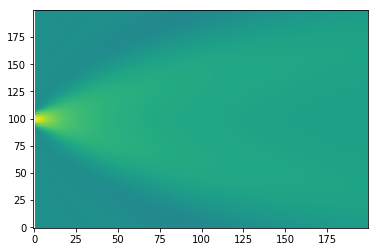

In [108]:
def Solution(t, x, z):
    z0 = k * w0 ** 2. / 2.
    
    return a0 / (1. + (z / z0) ** 2) ** 0.25 * exp(-(x / w0) ** 2. / (1. + (z / z0) ** 2.)) \
        * cos(x ** 2. / (2. * z * (z0 * w0 ** 2. / 2. + 1. / k)) + math.atan(-z / z0) / 2.) \
        #* sin(w * t - k * z + phi0) * Envelope(t, z)

S = np.empty((nofxs, nofzs))

for i in range(nofxs):
    for j in range(nofzs):
        S[i, j] = Solution(dt * N, -Lx / 2. + i * dx, j * dz)

imshow(S, aspect = 'auto', origin = 'lower', vmin = -a0, vmax = a0)

### Miscellaneous

In [1]:
tt = linspace(0, 10*2*pi, 200)

ttt,xxx=meshgrid(tt,x)
tocheck = Source(ttt,xxx,z=0)

subplot(211)
imshow(tocheck)

subplot(212)
plot(tocheck[50,:])


NameError: name 'linspace' is not defined